<a href="https://colab.research.google.com/github/dhruvnigam93/notebooks/blob/main/TabularEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import shap
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the Boston Housing dataset
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target

print("California Housing Dataset loaded:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Features: {housing.feature_names}")
print("\nFirst few rows of the dataset:")
print(X.head())
print("\nTarget variable statistics:")
print(pd.Series(y).describe())


California Housing Dataset loaded:
Number of samples: 20640
Number of features: 8
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

First few rows of the dataset:
   MedInc  HouseAge  AveRooms  ...  AveOccup  Latitude  Longitude
0  8.3252      41.0  6.984127  ...  2.555556     37.88    -122.23
1  8.3014      21.0  6.238137  ...  2.109842     37.86    -122.22
2  7.2574      52.0  8.288136  ...  2.802260     37.85    -122.24
3  5.6431      52.0  5.817352  ...  2.547945     37.85    -122.25
4  3.8462      52.0  6.281853  ...  2.181467     37.85    -122.25

[5 rows x 8 columns]

Target variable statistics:
count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
dtype: float64


In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Train a Random Forest Regressor
print("\nTraining Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")




Training Random Forest model...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading /local_disk0/user_tmp_data/root/tmpasxr7xrj/model/model.pkl:   0%|          | 0.00/1.35G [00:00<?, ?…

Model Performance:
Mean Squared Error: 0.2517
R² Score: 0.8079


In [ ]:


# 1. ShapCA Implementation
print("\nImplementing ShapCA (SHAP + PCA)...")

# Calculate SHAP values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled_df)

# Convert SHAP values to a DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_test_scaled_df.columns)
print("Got shap")
# Apply PCA to SHAP values
pca = PCA(n_components=2)
shapca_embedding = pca.fit_transform(shap_df)
print("Got embeddings")


Implementing ShapCA (SHAP + PCA)...
Got shap


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Got embeddings


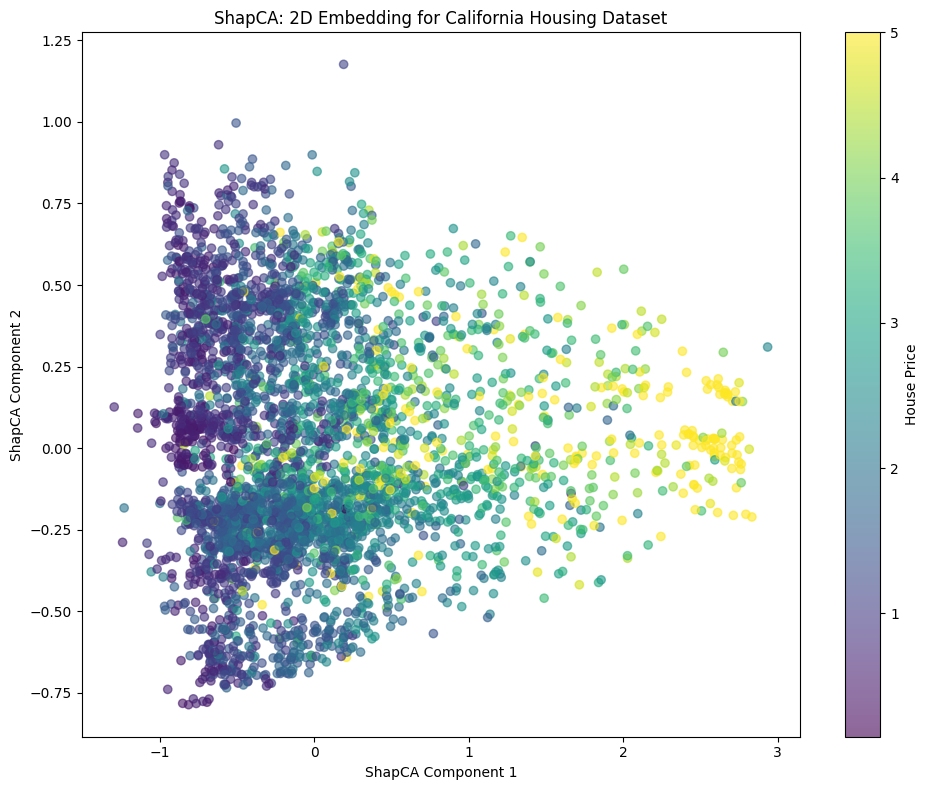

ShapCA explained variance ratio: [0.64427041 0.14215132]
Total explained variance: 0.7864


In [ ]:
# Visualize ShapCA embedding
plt.figure(figsize=(10, 8))
sc = plt.scatter(shapca_embedding[:, 0], shapca_embedding[:, 1], c=y_test, cmap='viridis', alpha=0.6)
plt.colorbar(sc, label='House Price')
plt.title('ShapCA: 2D Embedding for California Housing Dataset')
plt.xlabel('ShapCA Component 1')
plt.ylabel('ShapCA Component 2')
plt.tight_layout()
plt.savefig('shapca_embedding.png')
plt.show()
plt.close()

# Calculate explained variance ratio
shapca_explained_variance = pca.explained_variance_ratio_
print(f"ShapCA explained variance ratio: {shapca_explained_variance}")
print(f"Total explained variance: {sum(shapca_explained_variance):.4f}")



Implementing RFSNE (Random Forest + t-SNE)...
Computing proximity matrix...
Applying t-SNE...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

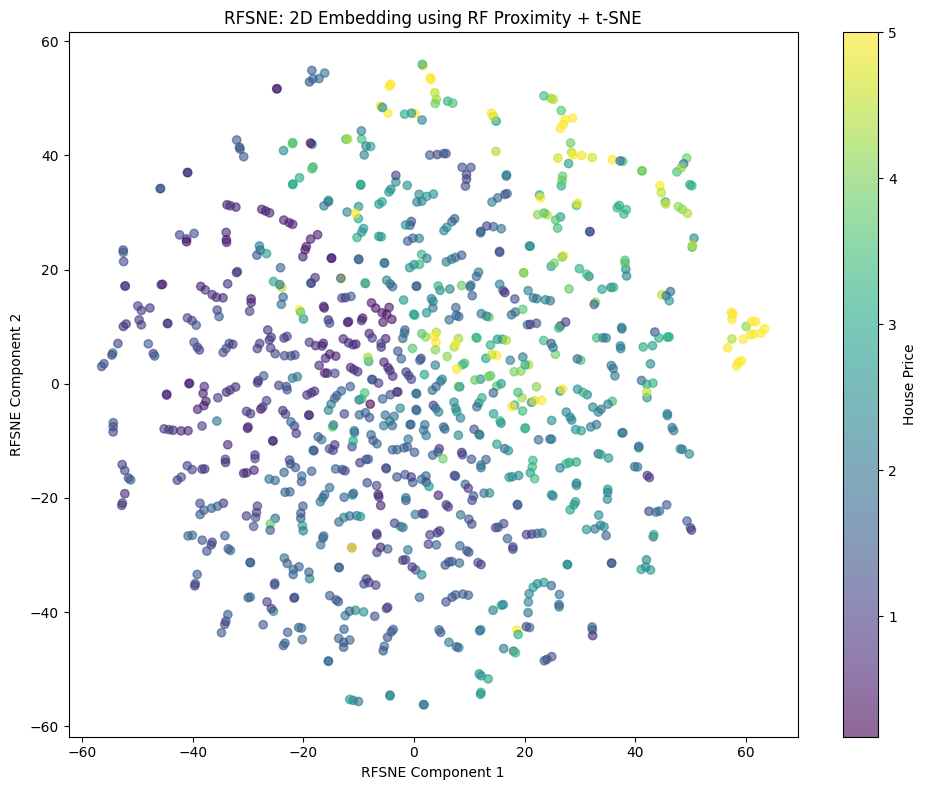

In [ ]:

# 2. RFSNE Implementation (Random Forest + t-SNE)
print("\nImplementing RFSNE (Random Forest + t-SNE)...")

def compute_proximity_matrix(rf_model, X):
    """Compute proximity matrix from Random Forest model"""
    # Get leaf indices for each sample in each tree
    terminals = []
    for tree in rf_model.estimators_:
        terminals.append(tree.apply(X))

    terminals = np.array(terminals)
    n_samples = X.shape[0]
    proximity_matrix = np.zeros((n_samples, n_samples))

    # Count how many times each pair of samples end up in the same leaf
    for i in range(n_samples):
        for j in range(i, n_samples):
            # Count how many times samples i and j are in the same terminal node
            same_leaf = np.sum(terminals[:, i] == terminals[:, j])
            proximity = same_leaf / len(rf_model.estimators_)
            proximity_matrix[i, j] = proximity
            proximity_matrix[j, i] = proximity  # Symmetrical

    return proximity_matrix

# Sample a subset of data for proximity calculation (for efficiency)
sample_size = min(1000, X_test_scaled.shape[0])
random_indices = np.random.choice(X_test_scaled.shape[0], sample_size, replace=False)
X_sample = X_test_scaled[random_indices]
y_sample = y_test[random_indices]

# Compute proximity matrix
print("Computing proximity matrix...")
proximity_matrix = compute_proximity_matrix(rf_model, X_sample)

# Convert proximity to distance
# Proximity of 1 means identical, 0 means completely different
# For t-SNE, we need distance (1 - proximity)
distance_matrix = 1 - proximity_matrix

# Apply t-SNE to the distance matrix
print("Applying t-SNE...")
tsne = TSNE(n_components=2, metric='precomputed', random_state=42,init='random')
rfsne_embedding = tsne.fit_transform(distance_matrix)

# Visualize RFSNE embedding
plt.figure(figsize=(10, 8))
sc = plt.scatter(rfsne_embedding[:, 0], rfsne_embedding[:, 1], c=y_sample, cmap='viridis', alpha=0.6)
plt.colorbar(sc, label='House Price')
plt.title('RFSNE: 2D Embedding using RF Proximity + t-SNE')
plt.xlabel('RFSNE Component 1')
plt.ylabel('RFSNE Component 2')
plt.tight_layout()
plt.savefig('rfsne_embedding.png')
plt.show()
plt.close()



In [ ]:

# Compare with standard dimensionality reduction techniques
print("\nComparing with standard dimensionality reduction techniques...")

# PCA on raw features
pca_raw = PCA(n_components=2)
pca_embedding = pca_raw.fit_transform(X_test_scaled)

plt.figure(figsize=(10, 8))
sc = plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1], c=y_test, cmap='viridis', alpha=0.6)
plt.colorbar(sc, label='House Price')
plt.title('PCA: 2D Embedding of Raw Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()
plt.show()
plt.close()

# t-SNE on raw features
tsne_raw = TSNE(n_components=2, random_state=42)
tsne_embedding = tsne_raw.fit_transform(X_test_scaled[:1000])  # Using a subset for efficiency

plt.figure(figsize=(10, 8))
sc = plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=y_test[:1000], cmap='viridis', alpha=0.6)
plt.colorbar(sc, label='House Price')
plt.title('t-SNE: 2D Embedding of Raw Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()
plt.close()

  File <command-3016246257358102>, line 6
    shap_values = explainer.shap_values(X_test_scaled_df))
                                                         ^
SyntaxError: unmatched ')'


In [ ]:

# Evaluate the quality of the embeddings
# For this, we'll train a simple model on the 2D embeddings and see how well it predicts

# Function to evaluate embedding quality
def evaluate_embedding(embedding, y_true, name):
    rf_eval = RandomForestRegressor(n_estimators=50, random_state=42)
    X_train_embed, X_test_embed, y_train_embed, y_test_embed = train_test_split(
        embedding, y_true, test_size=0.3, random_state=42)

    rf_eval.fit(X_train_embed, y_train_embed)
    y_pred_embed = rf_eval.predict(X_test_embed)

    mse_embed = mean_squared_error(y_test_embed, y_pred_embed)
    r2_embed = r2_score(y_test_embed, y_pred_embed)

    return {
        'name': name,
        'mse': mse_embed,
        'r2': r2_embed
    }

# Evaluate all embeddings
embedding_results = []

# ShapCA
embedding_results.append(evaluate_embedding(shapca_embedding, y_test, 'ShapCA'))

# RFSNE
embedding_results.append(evaluate_embedding(rfsne_embedding, y_sample, 'RFSNE'))

# PCA
embedding_results.append(evaluate_embedding(pca_embedding, y_test, 'PCA'))

# t-SNE
embedding_results.append(evaluate_embedding(tsne_embedding, y_test[:1000], 't-SNE'))

# Display results
embedding_results_df = pd.DataFrame(embedding_results)
print("\nEmbedding Quality Comparison:")
print(embedding_results_df)

# Plot embedding quality comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='name', y='mse', data=embedding_results_df)
plt.title('MSE Comparison')
plt.ylabel('Mean Squared Error (lower is better)')
plt.xlabel('')

plt.subplot(1, 2, 2)
sns.barplot(x='name', y='r2', data=embedding_results_df)
plt.title('R² Comparison')
plt.ylabel('R² Score (higher is better)')
plt.xlabel('')

plt.tight_layout()
plt.show()
plt.close()


  File <command-3016246257358102>, line 6
    shap_values = explainer.shap_values(X_test_scaled_df))
                                                         ^
SyntaxError: unmatched ')'


In [ ]:

# Demonstration of how embeddings can be used for transfer learning
print("\nDemonstrating transfer learning with embeddings...")

# Let's create a synthetic task: predicting whether a house is in the top 25% of prices
median_price = np.median(y)
top_quartile_threshold = np.percentile(y, 75)
y_binary = (y > top_quartile_threshold).astype(int)

# Split again for the new task
X_train_tl, X_test_tl, y_train_tl, y_test_tl = train_test_split(
    X, y_binary, test_size=0.2, random_state=42)

# Train a model on the original features
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_orig = RandomForestClassifier(n_estimators=100, random_state=42)
rf_orig.fit(X_train_tl, y_train_tl)
y_pred_orig = rf_orig.predict(X_test_tl)
acc_orig = accuracy_score(y_test_tl, y_pred_orig)

print(f"\nOriginal features classification accuracy: {acc_orig:.4f}")
print("\nClassification Report (Original Features):")
print(classification_report(y_test_tl, y_pred_orig))

# Now, let's use our embeddings for transfer learning

# Generate ShapCA embeddings for the entire dataset
# First, we need SHAP values for all data
explainer_all = shap.TreeExplainer(rf_model)
shap_values_all = explainer_all.shap_values(X)
shap_df_all = pd.DataFrame(shap_values_all, columns=X.columns)

# Apply PCA to get ShapCA embeddings
pca_all = PCA(n_components=2)
shapca_all = pca_all.fit_transform(shap_df_all)

# Train a model on the ShapCA embeddings
X_train_shapca, X_test_shapca, y_train_shapca, y_test_shapca = train_test_split(
    shapca_all, y_binary, test_size=0.2, random_state=42)

rf_shapca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_shapca.fit(X_train_shapca, y_train_shapca)
y_pred_shapca = rf_shapca.predict(X_test_shapca)
acc_shapca = accuracy_score(y_test_shapca, y_pred_shapca)

print(f"\nShapCA embeddings classification accuracy: {acc_shapca:.4f}")
print("\nClassification Report (ShapCA Embeddings):")
print(classification_report(y_test_shapca, y_pred_shapca))

# Conclusion
print("\n=== Conclusion ===")
print("We've implemented and compared two embedding techniques for tabular data:")
print("1. ShapCA: Combining SHAP values with PCA")
print("2. RFSNE: Using Random Forest proximity with t-SNE")
print("\nBoth techniques demonstrated the ability to create meaningful embeddings that:")
print("- Transform features into a unified space")
print("- Provide context-aware, motivated compression")
print("- Capture relationships relevant to the prediction task")
print("\nThese embeddings can be visualized and used for transfer learning tasks.")

  File <command-3016246257358102>, line 6
    shap_values = explainer.shap_values(X_test_scaled_df))
                                                         ^
SyntaxError: unmatched ')'


In [ ]:
shap_df.display()

  File <command-3016246257358102>, line 6
    shap_values = explainer.shap_values(X_test_scaled_df))
                                                         ^
SyntaxError: unmatched ')'
